# SVM

## Two Trail Classification

### load data

Mat文件：OSPersonX
- 变量：OS：要分析的数据，36x52x40x54 时间 * 频率 * Trial * pair
	- time：对应的时间点在Time变量中
	- 频率：对应的频率在fOS变量中
	- Trial：同样为40个Trail或10个Trial，顺序和Track对应。
	- Pair：这里Pair指的是54个感兴趣的两个通道之间的配对。对应的Pair编号在Pair54.mat文件中。

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.io as sio
import numpy as np

In [80]:
rawTracePerson1 = sio.loadmat("data/Person1/rawTracePerson1.mat", variable_names = ["Track", "dataTrial"])
rawTracePerson2 = sio.loadmat("data/Person2/rawTracePerson2.mat", variable_names = ["Track", "dataTrial"])
rawTracePerson3 = sio.loadmat("data/Person3/rawTracePerson3.mat", variable_names = ["Track", "dataTrial"])
rawTracePerson4 = sio.loadmat("data/Person4/rawTracePerson4.mat", variable_names = ["Track", "dataTrial"])


track1, data_trial1 =  rawTracePerson1["Track"], rawTracePerson1["dataTrial"]
track2, data_trial2 =  rawTracePerson2["Track"], rawTracePerson2["dataTrial"]
track3, data_trial3 =  rawTracePerson3["Track"], rawTracePerson3["dataTrial"]
track4, data_trial4 =  rawTracePerson4["Track"], rawTracePerson4["dataTrial"]
trials = np.concatenate((track1, track2, track3, track4), axis=1)[0]
# trials = track1[0]
trials.shape

(100,)

In [81]:
OSPerson1 = sio.loadmat("data/Person1/OSPerson1.mat")
OSPerson2 = sio.loadmat("data/Person2/OSPerson2.mat")
OSPerson3 = sio.loadmat("data/Person3/OSPerson3.mat")
OSPerson4 = sio.loadmat("data/Person4/OSPerson4.mat")
theta = OSPerson1["fOS"][4:14]
gamma = OSPerson1["fOS"][33:-1]
alpha = OSPerson1["fOS"][15:20]

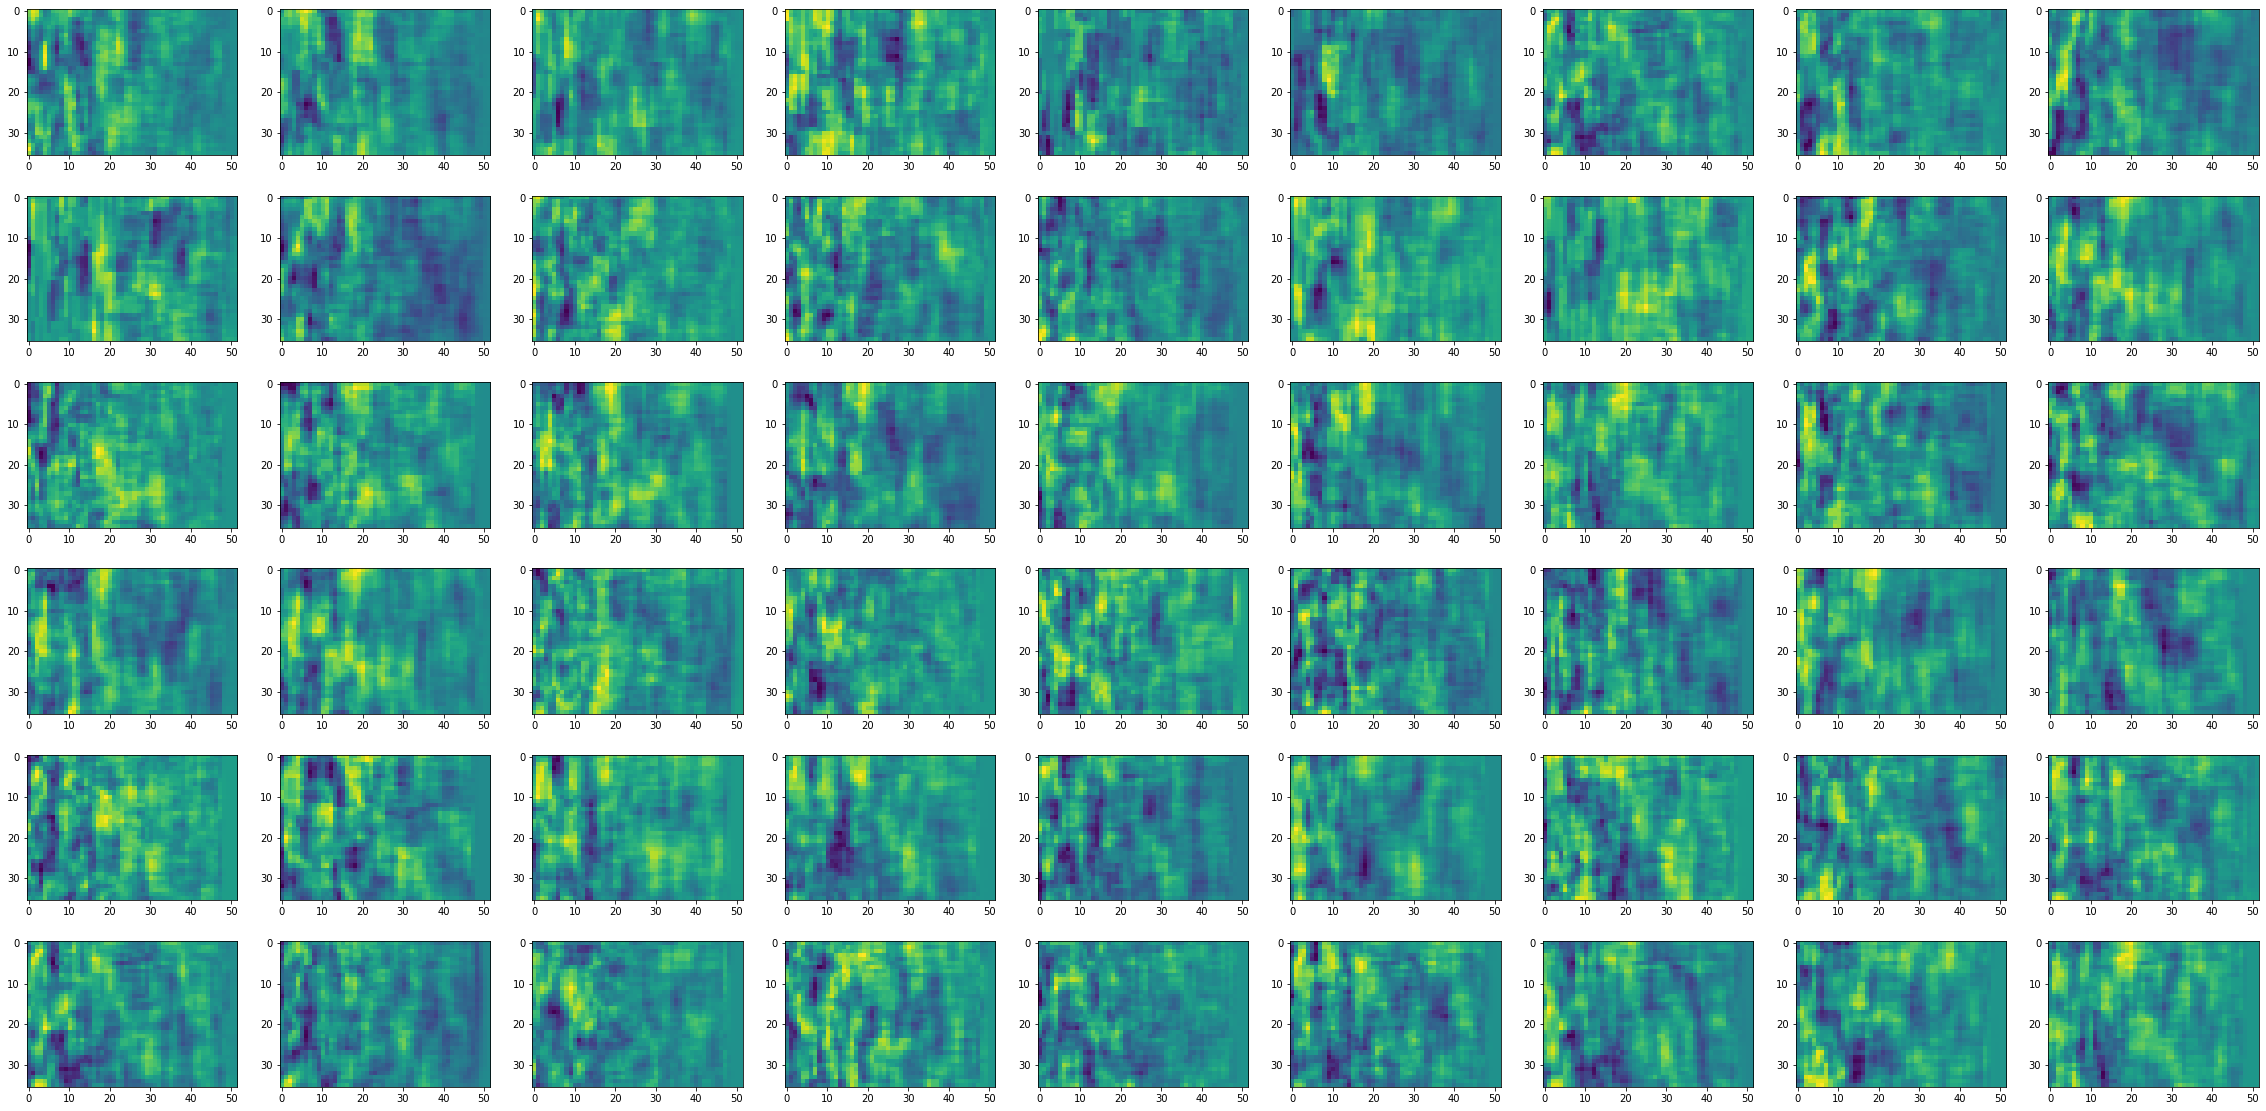

In [82]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 20))
sums = []
for i in range(54):
    plt.subplot(6, 9, i+1)
    # 创建一个二维数组作为热力图的数据
    data = OSPerson1["OS"][:,:,0,i] - OSPerson1["OS"][:,:,4,i]
    sums.append(data.sum())

    # 使用imshow函数绘制热力图
    plt.imshow(data, interpolation='nearest')

    # # 添加颜色条
    # plt.colorbar()

    # 显示热力图
    # plt.colorbar()
plt.show()

In [83]:
sums = [abs(i) for i in sums]
# 使用argpartition找出前三大的索引

# 使用argpartition找出前10大的索引
top10_indices = np.argpartition(sums, -10)[-10:]

# 使用索引对应的值进行排序
sorted_indices = top10_indices[np.argsort(-np.array(sums)[top10_indices])]

# 打印排序后的索引
print("Most Different PLV value:", sorted_indices)

Most Different PLV value: [22 25 23 29 19 34 28 17 20 49]


In [84]:
trial_train_datas = []
for i in range(0,1):
    trial_datas = np.concatenate((OSPerson1["OS"][30:,4:14,:,[22, 23, 25]],
                                OSPerson2["OS"][30:,4:14,:,[22, 23, 25]], 
                                OSPerson3["OS"][30:,4:14,:,[22, 23, 25]],
                                OSPerson4["OS"][30:,4:14,:,[22, 23, 25]]),
                                axis=2)
    # trial_datas = OSPerson1["OS"][30:,4:14,:,0:16]
    trial_train_data = trial_datas.transpose([2,0,1,3])
    trial_train_data = trial_train_data.reshape((trial_train_data.shape[0], -1))
    print(trial_train_data.shape)
    trial_train_datas.append(trial_train_data)
# trial_train_datas

(100, 180)


In [85]:
trial_type = np.zeros(len(trials))

for num_trial in range(len(trials)):
    if trials[num_trial] <= 10:
        trial_type[num_trial] = 1

In [86]:
trial_type

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.])

In [87]:
# pca_data = trial_train_data[:,:]
# pca_data.shape

In [88]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# # 使用PCA对数据进行降维

# X_pca = pca.fit_transform(pca_data)

# # 输出降维后的数据和降维后的每个特征的解释方差比例
# print("降维后的数据：\n", X_pca)
# print("每个特征的解释方差比例：", pca.explained_variance_ratio_)

In [89]:
# X_pca.shape
trial_train_datas[0].shape

(100, 180)

### Train

In [90]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier


acc_list = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(trial_train_datas[0], trial_type, test_size=0.2, random_state=i)
    clf = svm.SVC(kernel='rbf',decision_function_shape='ovo', C=10.0)
    # clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    print("Accuracy:", acc)
# 计算列表的标准差
std_dev = np.std(acc_list)
# 打印标准差
print("标准差:", std_dev)
print(sum(acc_list)/20)

Accuracy: 0.45
Accuracy: 0.5
Accuracy: 0.45
Accuracy: 0.5
Accuracy: 0.65
Accuracy: 0.45
Accuracy: 0.55
Accuracy: 0.6
Accuracy: 0.65
Accuracy: 0.55
Accuracy: 0.65
Accuracy: 0.6
Accuracy: 0.55
Accuracy: 0.55
Accuracy: 0.65
Accuracy: 0.5
Accuracy: 0.4
Accuracy: 0.55
Accuracy: 0.5
Accuracy: 0.5
标准差: 0.07348469228349536
0.69


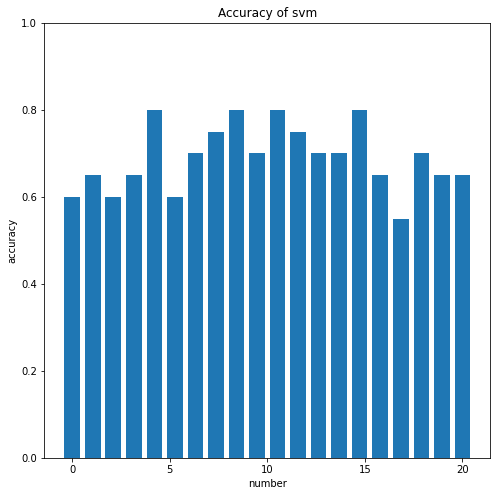

In [91]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8)) 
plt.ylim(0, 1)
x_axis = np.linspace(0,len(acc_list),len(acc_list))
plt.title("Accuracy of svm")
plt.ylabel("accuracy")
plt.xlabel("number")

plt.bar(x_axis, acc_list)
plt.show()

## Image Classification

In [116]:
%reset

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.io as sio
import numpy as np

In [23]:
rawTracePerson1 = sio.loadmat("data/Person1/rawTracePerson1.mat", variable_names = ["Track", "dataTrial"])
track, data_trial =  rawTracePerson1["Track"], rawTracePerson1["dataTrial"]
trials = track[0]
trials

array([18, 16, 16, 17,  8, 12, 19, 18, 10, 15, 20, 18,  9, 15, 18, 19, 13,
       12,  6,  2,  7, 16, 12, 12, 13, 11, 10,  5,  9,  2,  5,  5,  2, 10,
        2,  4,  1,  3,  8,  5], dtype=uint8)

In [24]:
OSPerson1 = sio.loadmat("data/Person1/OSPerson1.mat")
frequence = OSPerson1["fOS"][4:14]
frequence

array([[4.05269913],
       [4.34357537],
       [4.65532882],
       [4.98945789],
       [5.34756856],
       [5.73138207],
       [6.1427432 ],
       [6.58362915],
       [7.05615901],
       [7.56260398]])

In [63]:
trial_datas = OSPerson1["OS"][:,4:14,:,:]
trial_datas.shape

(36, 10, 40, 54)

In [64]:
img_type = np.zeros(40)

for num_trial in range(len(trial_datas[0,0,:,0])):
    if trials[num_trial] <= 10:
        img_type[num_trial] = trials[num_trial]
    else:
        img_type[num_trial] = 0

In [65]:
img_type

array([ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  9.,
        0.,  0.,  0.,  0.,  0.,  6.,  2.,  7.,  0.,  0.,  0.,  0.,  0.,
       10.,  5.,  9.,  2.,  5.,  5.,  2., 10.,  2.,  4.,  1.,  3.,  8.,
        5.])

In [66]:
trial_train_data = []
for i in range(len(img_type)):
    if img_type[i] != 0:
        trial_train_data.append(trial_datas[:,:,i,:])
trial_train_data = np.array(trial_train_data)
trial_train_data.shape

(20, 36, 10, 54)

In [67]:
trial_train_data = trial_train_data.reshape((trial_train_data.shape[0], -1))
trial_train_data.shape

(20, 19440)

In [68]:
img_type = img_type[np.nonzero(img_type)]
img_type

array([ 8., 10.,  9.,  6.,  2.,  7., 10.,  5.,  9.,  2.,  5.,  5.,  2.,
       10.,  2.,  4.,  1.,  3.,  8.,  5.])

In [69]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(trial_train_data, img_type, test_size=0.2, random_state=20)
y_test

array([ 1., 10.,  5.,  2.])

In [70]:
clf = svm.SVC(decision_function_shape='ovo', kernel="rbf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.25


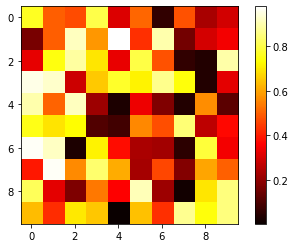

In [361]:
import numpy as np
import matplotlib.pyplot as plt

# 创建一个二维数组作为热力图的数据
data = np.random.random((10, 10))

# 使用imshow函数绘制热力图
plt.imshow(data, cmap='hot', interpolation='nearest')

# 添加颜色条
plt.colorbar()

# 显示热力图
plt.show()
